## Saving a Chiikawa vs Hachiware Model

This is a minimal example showing how to train a fastai model on Kaggle, and save it so you can use it in your app.

用于在huggingface上部署Chiikawa VS Hachiware 识别器模型

In [1]:
# Make sure we've got the latest version of fastai:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")


In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install  'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.8 MB/s eta 0:00:0000:0100:01


First, import all the stuff we need from fastai:

In [5]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *
from fastai.vision.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

下载chiikawa和hachiware的图片

先尝试用ddgs搜索一下chiikawa和hachiware

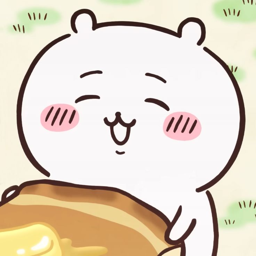

In [10]:
from fastdownload import download_url
download_url(search_images('chiikawa oneself photos', max_images=1)[0], 'chiikawa.jpg', show_progress=True)
im = Image.open('chiikawa.jpg')
im.to_thumb(256,256)

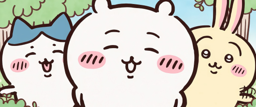

In [11]:
download_url(search_images('hachiware oneself photos', max_images=1)[0], 'hachiware.jpg', show_progress=True)
im = Image.open('hachiware.jpg')
im.to_thumb(256,256)

发现因为Chiikawa也是这部动画片的名字, 单独用Chiikawa搜索会搜出三者的图片

尝试加上oneself

In [43]:
searches = 'chiikawa', 'hachiware'
path = Path('chiikawa_vs_hachiware')
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} oneself photos'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)
    

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


下载Chiikawa和Hachiware的图片

In [44]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

37

清理下载失败的图片

In [45]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

定义数据加载器

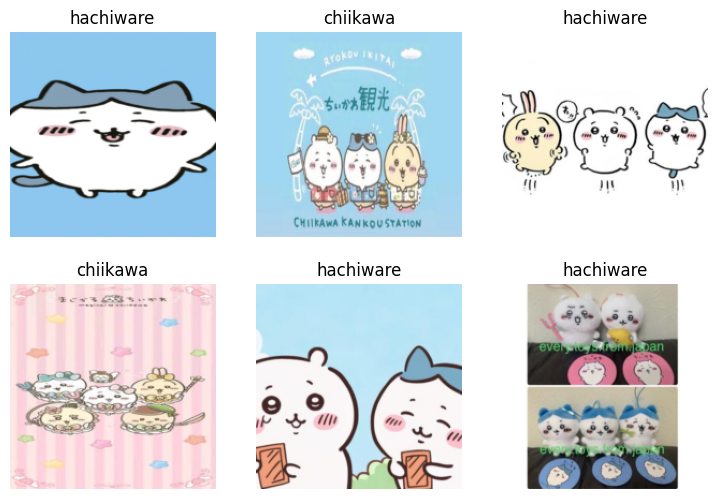

In [46]:
dls.show_batch(max_n=6)

## 开始数据清理

数据清理前要先训练一个模型

In [47]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.036497,0.868726,0.253968,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.564540,0.453215,0.142857,00:01
1,0.429860,0.573839,0.150794,00:01
2,0.329721,0.538513,0.126984,00:02
3,0.259307,0.515342,0.103175,00:02


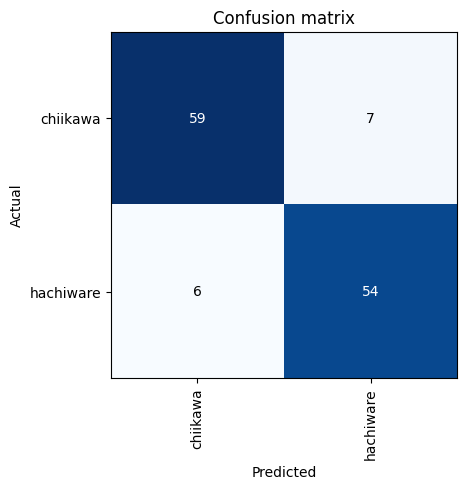

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

展示一下混淆矩阵

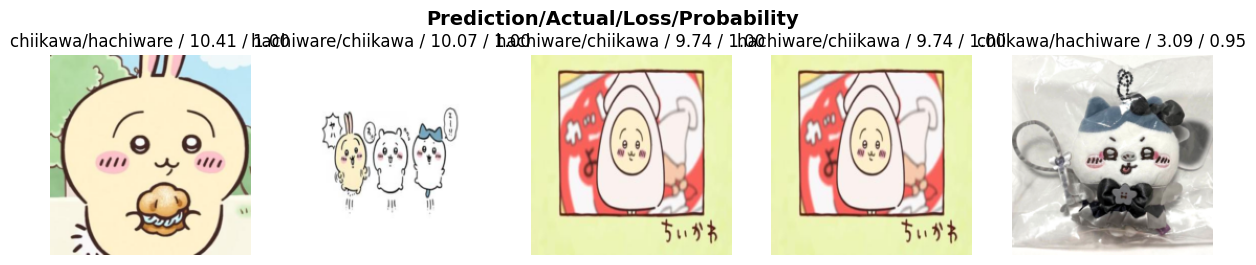

In [49]:
interp.plot_top_losses(5, nrows=1)

展示一下损失较大的几个数据, 发现主要是由于chiikawa的图片经常会包含别的角色

In [51]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

人为挑选进行数据清理

In [52]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [53]:
for idx,chiikawa in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/chiikawa)

## 数据清洗完成, 开始训练模型

In [54]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)
learn_after_clean = vision_learner(dls, resnet18, metrics=error_rate)
learn_after_clean.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.894650,0.749905,0.285714,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.610038,0.535368,0.230159,00:02
1,0.448479,0.467016,0.119048,00:01
2,0.354555,0.457685,0.126984,00:02
3,0.283485,0.444364,0.126984,00:02


In [ ]:
path = untar_data(URLs.PETS)/'images'

We need a way to label our images as dogs or cats. In this dataset, pictures of cats are given a filename that starts with a capital letter:

In [ ]:
def is_cat(x): return x[0].isupper() 

Now we can create our `DataLoaders`:

In [ ]:
dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat,
    item_tfms=Resize(192))

... and train our model, a resnet18 (to keep it small and fast):

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Now we can export our trained `Learner`. This contains all the information needed to run the model:

In [ ]:
learn.export('model.pkl')

Finally, open the Kaggle sidebar on the right if it's not already, and find the section marked "Output". Open the `/kaggle/working` folder, and you'll see `model.pkl`. Click on it, then click on the menu on the right that appears, and choose "Download". After a few seconds, your model will be downloaded to your computer, where you can then create your app that uses the model.